### ARIMA-TimeSeries Analysis of Tractor Sales

In [2]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

#### Step 1: Visualize Tractor Sales data as time series

In [3]:
sales_data = pd.read_csv("Tractor-Sales.csv")
sales_data.head(5)

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [4]:
sales_data.tail()

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month-Year                144 non-null object
Number of Tractor Sold    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [7]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [8]:
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [9]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [10]:
sales_data.head()

,Month-Year,Number of Tractor Sold,Month,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [11]:
sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]

In [12]:
sales_data.head()

,Month,Year,Tractor-Sales
0,Jan,2003,141
1,Feb,2003,157
2,Mar,2003,185
3,Apr,2003,199
4,May,2003,203


In [13]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
Month            144 non-null object
Year             144 non-null int64
Tractor-Sales    144 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [14]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [15]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [16]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2003-01-01 to 2014-12-01
Freq: MS
Data columns (total 3 columns):
Month            144 non-null object
Year             144 non-null int64
Tractor-Sales    144 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.5+ KB


In [17]:
# extract out the time-series
sales_ts = sales_data['Tractor-Sales']

In [18]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

C:\Users\Prakhar\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


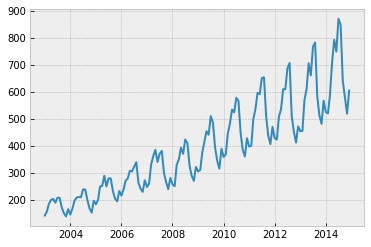

In [19]:
plt.plot(sales_ts)

Text(0, 0.5, 'Tractor Sales')

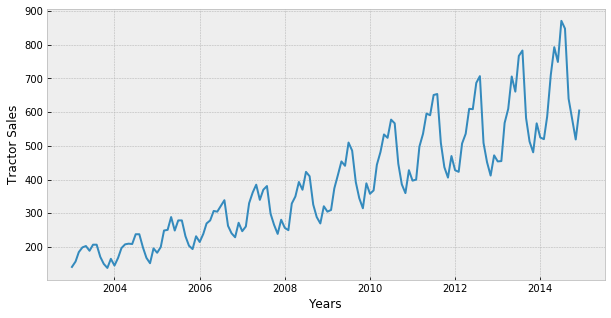

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

##### Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.



In [21]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

In [22]:
sales_ts.rolling(window=4).mean()

2003-01-01       NaN
2003-02-01       NaN
2003-03-01       NaN
2003-04-01    170.50
2003-05-01    186.00
               ...  
2014-08-01    815.25
2014-09-01    777.00
2014-10-01    735.00
2014-11-01    647.00
2014-12-01    586.25
Freq: MS, Name: Tractor-Sales, Length: 144, dtype: float64

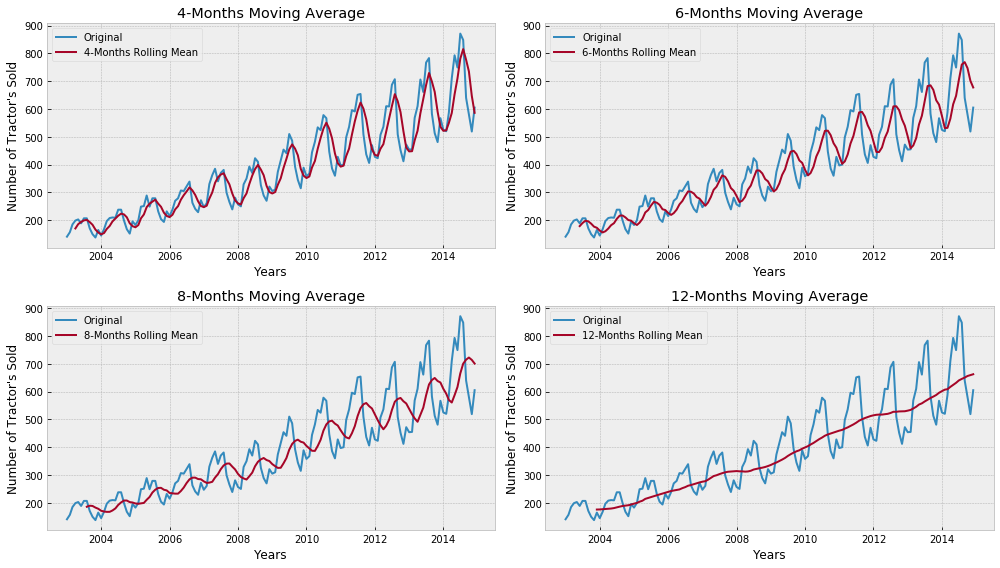

In [23]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

#### Step 1.2: Seasonality – Time Series Decomposition

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [24]:
sales_data.head()

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [25]:
monthly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


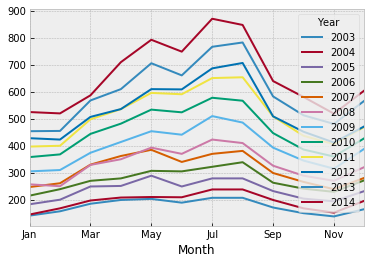

In [26]:
monthly_sales_data.plot()

In [27]:
yearly_sales_data = pd.pivot_table(sales_data, values = "Tractor-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


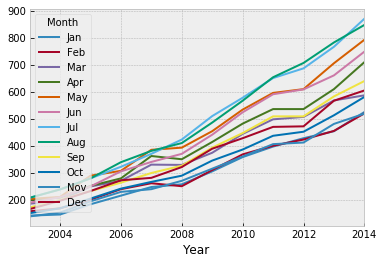

In [28]:
yearly_sales_data.plot()

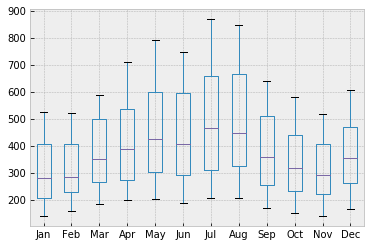

In [29]:
yearly_sales_data.boxplot()

#### Important Inferences

The tractor sales have been increasing without fail every year.

July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.

We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year. We can see a seasonal effect with a cycle of 12 months.


In [30]:
sm.tsa.seasonal_decompose?

In [31]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative',two_sided=False, extrapolate_trend=4)

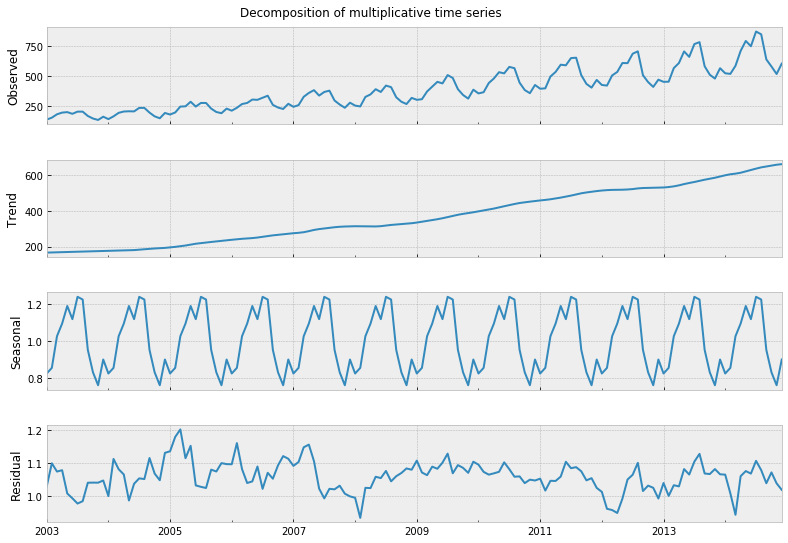

In [32]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [33]:
decomposition.trend.head()

2003-01-01    166.408333
2003-02-01    167.216667
2003-03-01    168.025000
2003-04-01    168.833333
2003-05-01    169.641667
Freq: MS, Name: Tractor-Sales, dtype: float64

In [34]:
decomp_output = pd.DataFrame(pd.concat([decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid], axis=1))

In [35]:
decomp_output.columns = ['observed', 'Trend', 'Seasonal', 'Irregular']

In [36]:
decomp_output['TSI'] = decomp_output.Trend*decomp_output.Seasonal*decomp_output.Irregular

In [120]:
decomp_output.head()

,observed,Trend,Seasonal,Irregular,TSI
2003-01-01,141,166.408333,0.823508,1.028907,141.0
2003-02-01,157,167.216667,0.853891,1.099557,157.0
2003-03-01,185,168.025000,1.024830,1.074350,185.0
2003-04-01,199,168.833333,1.092962,1.078424,199.0
2003-05-01,203,169.641667,1.187805,1.007438,203.0


### Dickey-Fuller Test 
- Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [38]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

In [39]:
adfuller(sales_ts)

(1.1088250591467375,
 0.995291241524842,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1082.5357724796872)

In [40]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, rolling mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

As we observed while plotting the moving average over months that there is a monhly pattern, now, let’s decipher the seasonal component.

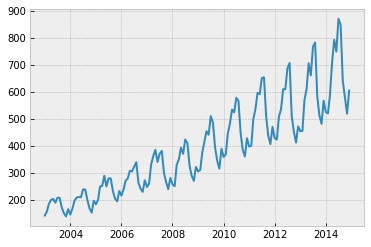

In [41]:
plt.plot(sales_ts)

In [42]:
sales_ts_log = np.log10(sales_ts)

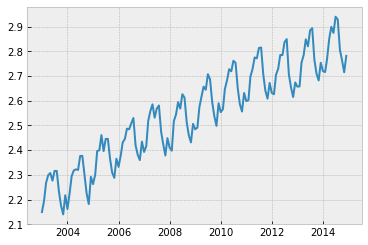

In [43]:
plt.plot(sales_ts_log)

In [44]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.732472
p-value                          0.414464
#lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [45]:
sales_ts.head()

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
Freq: MS, Name: Tractor-Sales, dtype: int64

In [46]:
sales_ts.diff(1).head()

2003-01-01     NaN
2003-02-01    16.0
2003-03-01    28.0
2003-04-01    14.0
2003-05-01     4.0
Freq: MS, Name: Tractor-Sales, dtype: float64

In [47]:
sales_ts_diff1 = sales_ts.diff(1)
sales_ts_diff1.dropna(inplace=True)

In [48]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.543481
p-value                          0.105250
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [49]:
sales_ts_log_diff1 = sales_ts_log.diff(1)
sales_ts_log_diff1.dropna(inplace=True)

In [50]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.680467
p-value                          0.077480
#lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [51]:
sales_ts_log_diff2 = sales_ts_log.diff(2)
sales_ts_log_diff2.dropna(inplace=True)

In [52]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts_log_diff2)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.200722
p-value                          0.019943
#lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


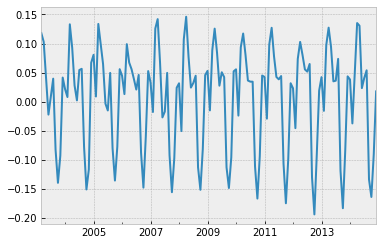

In [53]:
sales_ts_log_diff2.plot()

#### Step 2: Difference data to make data stationary on mean (remove trend)
Clearly the tractor sales has an upward trend for tractors sales and there is also a seasonal component that we have already analyzed.

The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series using the following formula:

1st Differencing (d=1) |  Y′t=Yt−Yt−1

C:\Users\Prakhar\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


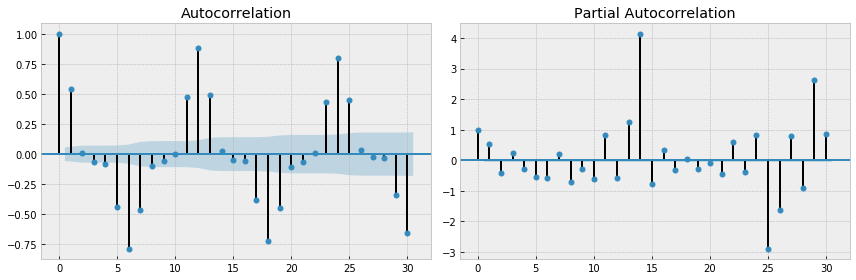

In [54]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [55]:
sm.tsa.statespace.SARIMAX?

In [56]:
model = sm.tsa.statespace.SARIMAX(sales_ts_log, order = (1,2,1), seasonal_order= (1,0,0,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

In [57]:
results = model.fit()

In [58]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(1, 2, 1)x(1, 0, 0, 12)   Log Likelihood                 329.109
Date:                            Sun, 22 Dec 2019   AIC                           -650.219
Time:                                    19:28:31   BIC                           -638.780
Sample:                                01-01-2003   HQIC                          -645.571
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3411      0.066     -5.154      0.000      -0.471      -0.211
ma.L1         -1.0000     39.726   

### Iterate the process to find the best values for p, d, q and P, D, Q

In [59]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(2,3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

In [60]:
pdq

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [61]:
# Generate all different combinations of seasonal p, q and q triplets
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [62]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [63]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.2934462838832


Best SARIMAX(1, 2, 1)x(1, 0, 1, 12)12 model - AIC:-673.2934415061015
The best fit model is selected based on Akaike Information Criterion (AIC) , and Bayesian Information Criterion (BIC) values. The idea is to choose a model with minimum AIC and BIC values.

#### Akaike Information Criterion (AIC) 
- AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L)AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

#### Step 7: Predict sales on in-sample date using the best fit ARIMA model
The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [64]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(1, 2, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [65]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood                 341.647
Date:                            Sun, 22 Dec 2019   AIC                           -673.293
Time:                                    19:30:09   BIC                           -659.033
Sample:                                01-01-2003   HQIC                          -667.499
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3573      0.073     -4.893      0.000      -0.500      -0.214
ma.L1         -1.0002      7.012   

In [66]:
sales_ts

2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
             ... 
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, Length: 144, dtype: int64

In [67]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

In [68]:
pred_dynamic.predicted_mean

2014-01-01    2.723840
2014-02-01    2.723639
2014-03-01    2.809683
2014-04-01    2.812627
2014-05-01    2.888854
2014-06-01    2.885717
2014-07-01    2.933833
2014-08-01    2.942464
2014-09-01    2.808346
2014-10-01    2.747033
2014-11-01    2.725420
2014-12-01    2.790543
Freq: MS, dtype: float64

In [69]:
np.power(10, pred_dynamic.predicted_mean)

2014-01-01    529.468266
2014-02-01    529.223689
2014-03-01    645.183857
2014-04-01    649.571157
2014-05-01    774.201454
2014-06-01    768.629139
2014-07-01    858.682510
2014-08-01    875.919179
2014-09-01    643.199395
2014-10-01    558.512790
2014-11-01    531.397954
2014-12-01    617.366658
Freq: MS, dtype: float64

In [70]:
sales_ts['2014-01-01':]

2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01    871
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, dtype: int64

In [71]:
forecast = np.power(10,pred_dynamic.predicted_mean)

In [72]:
actual = sales_ts['2014-01-01':]

In [73]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

In [74]:
print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))


The Mean Absolute percentage error of our forecast for last two years is 0.033


In [75]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 802.8743
The ROOT Mean Squared Error of our forecasts is 28.335036615469548


In [76]:
#Forecast for next 12 Months

In [77]:
np.power(10, best_results.forecast(steps=36))

2015-01-01     564.643537
2015-02-01     562.718261
2015-03-01     668.770275
2015-04-01     756.665151
2015-05-01     854.608586
2015-06-01     815.159056
2015-07-01     937.516916
2015-08-01     932.924285
2015-09-01     698.778092
2015-10-01     620.923219
2015-11-01     565.453687
2015-12-01     662.411869
2016-01-01     616.863204
2016-02-01     614.907741
2016-03-01     731.434301
2016-04-01     828.186807
2016-05-01     935.995210
2016-06-01     892.256864
2016-07-01    1027.015052
2016-08-01    1021.694464
2016-09-01     763.410551
2016-10-01     677.581992
2016-11-01     616.462313
2016-12-01     722.852112
2017-01-01     672.618895
2017-02-01     670.304811
2017-03-01     798.177848
2017-04-01     904.383977
2017-05-01    1022.803674
2017-06-01     974.415373
2017-07-01    1122.496868
2017-08-01    1116.361683
2017-09-01     832.105638
2017-10-01     737.706212
2017-11-01     670.518157
2017-12-01     786.988575
Freq: MS, dtype: float64

#### Step 8: Forecast sales using the best fit ARIMA model
The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [78]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [79]:
pred_ci_99.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,2.719983,2.783566
2015-02-01,2.712329,2.788253
2015-03-01,2.779819,2.870735
2015-04-01,2.827596,2.930212
2015-05-01,2.874896,2.988639


In [80]:
pred_ci_95.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,2.719983,2.783566
2015-02-01,2.712329,2.788253
2015-03-01,2.779819,2.870735
2015-04-01,2.827596,2.930212
2015-05-01,2.874896,2.988639


In [81]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

In [82]:
fc_95.head()

,forecast,lower_ci_95,upper_ci_95
2014-12-01,564.643537,524.786786,607.527347
2015-01-01,562.718261,515.619139,614.119641
2015-02-01,668.770275,602.308695,742.565539
2015-03-01,756.665151,672.350379,851.553251
2015-04-01,854.608586,749.713970,974.179307


In [83]:
fc_99.head()

,lower_ci_99,upper_ci_99
2014-12-01,524.786786,607.527347
2015-01-01,515.619139,614.119641
2015-02-01,602.308695,742.565539
2015-03-01,672.350379,851.553251
2015-04-01,749.713970,974.179307


In [84]:
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,564.643537,524.786786,607.527347,524.786786,607.527347
2015-01-01,562.718261,515.619139,614.119641,515.619139,614.119641
2015-02-01,668.770275,602.308695,742.565539,602.308695,742.565539
2015-03-01,756.665151,672.350379,851.553251,672.350379,851.553251
2015-04-01,854.608586,749.713970,974.179307,749.713970,974.179307


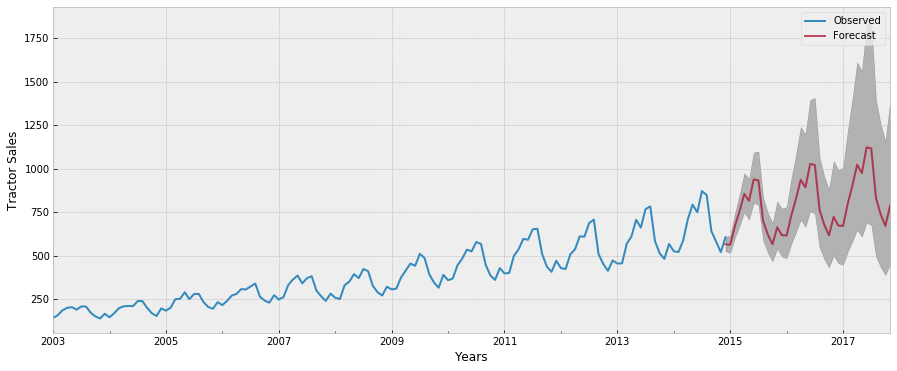

In [85]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [86]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)

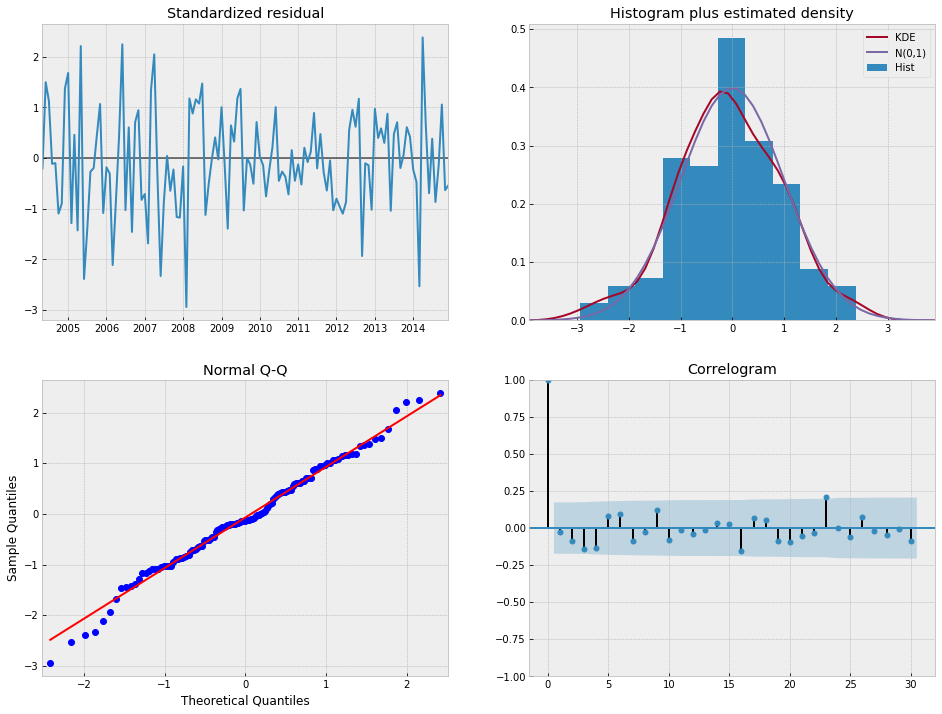

In [87]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

In [88]:
sm.tsa.SARIMAX?

In [89]:
mkt_sales_data = pd.read_csv('sales-and-marketing.csv')

In [90]:
mkt_sales_data.head()

,Time Period,Sales,Marketing Expense
0,Jan-11,397,486.64
1,Feb-11,400,501.80
2,Mar-11,498,437.09
3,Apr-11,536,565.16
4,May-11,596,744.15


In [91]:
# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

In [92]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.434334
p-value                         0.997265
#lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


In [93]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

In [94]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(mkt_sales_data_diff['Tractor-Sales'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.015650e+00
p-value                        6.743731e-10
#lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


The correlation for the previous quarter also shows non-existent correlation with sales. Now, let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [95]:
mkt_sales_data['Mkt_Exp_Lag_1'] = mkt_sales_data['Marketing Expense'].shift(1)
mkt_sales_data['Mkt_Exp_Lag_2'] = mkt_sales_data['Marketing Expense'].shift(2)
mkt_sales_data['Mkt_Exp_Lag_3'] = mkt_sales_data['Marketing Expense'].shift(3)
mkt_sales_data['Mkt_Exp_Lag_4'] = mkt_sales_data['Marketing Expense'].shift(4)

In [96]:
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-01-01,397,486.64,NaN,NaN,NaN,NaN
2011-02-01,400,501.80,486.64,NaN,NaN,NaN
2011-03-01,498,437.09,501.80,486.64,NaN,NaN
2011-04-01,536,565.16,437.09,501.80,486.64,NaN
2011-05-01,596,744.15,565.16,437.09,501.80,486.64


In [97]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [98]:
mkt_sales_data.dropna(inplace=True)
mkt_sales_data.head()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15


In [99]:
mkt_sales_data.corr()

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
Tractor-Sales,1.000000,0.807838,0.585169,0.262011,-0.056909,-0.257012
Marketing Expense,0.807838,1.000000,0.626329,0.380395,0.140597,-0.130755
Mkt_Exp_Lag_1,0.585169,0.626329,1.000000,0.622385,0.380459,0.145967
Mkt_Exp_Lag_2,0.262011,0.380395,0.622385,1.000000,0.625423,0.398619
Mkt_Exp_Lag_3,-0.056909,0.140597,0.380459,0.625423,1.000000,0.634986
Mkt_Exp_Lag_4,-0.257012,-0.130755,0.145967,0.398619,0.634986,1.000000


In [100]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = mkt_sales_data["Tractor-Sales"]
regressors = mkt_sales_data[["Marketing Expense", "Mkt_Exp_Lag_1", "Mkt_Exp_Lag_2"]]
best_results = auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 2), q=range(0, 2),
                         P=range(0, 2), D=range(0, 1), Q=range(0, 2))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:273.48438715733323
                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -129.742
Date:                            Sun, 22 Dec 2019   AIC                            273.484
Time:                                    19:30:28   BIC                            283.055
Sample:                                05-01-2011   HQIC                           276.482
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0287   

In [101]:
best_model = sm.tsa.statespace.SARIMAX(timeseries,
                                      exog = regressors,
                                      order=(1, 1, 0),
                                      seasonal_order=(1, 0, 0, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [102]:
print(best_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Tractor-Sales   No. Observations:                   44
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -135.148
Date:                            Sun, 22 Dec 2019   AIC                            282.295
Time:                                    19:30:29   BIC                            290.702
Sample:                                05-01-2011   HQIC                           284.985
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Marketing Expense     0.0016      0.041      0.040      0.968      -0.080       0.083
Mkt_Exp_Lag_1 

In [103]:
mkt_sales_data

,Tractor-Sales,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2,Mkt_Exp_Lag_3,Mkt_Exp_Lag_4
2011-05-01,596,744.15,565.16,437.09,501.80,486.64
2011-06-01,591,548.74,744.15,565.16,437.09,501.80
2011-07-01,651,650.21,548.74,744.15,565.16,437.09
2011-08-01,654,777.51,650.21,548.74,744.15,565.16
2011-09-01,509,547.11,777.51,650.21,548.74,744.15
2011-10-01,437,382.81,547.11,777.51,650.21,548.74
2011-11-01,406,551.56,382.81,547.11,777.51,650.21
2011-12-01,470,401.69,551.56,382.81,547.11,777.51
2012-01-01,428,370.97,401.69,551.56,382.81,547.11
2012-02-01,423,318.39,370.97,401.69,551.56,382.81


In [104]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), full_results=True)

pred_dynamic.predicted_mean

2014-01-01    532.391295
2014-02-01    528.597682
2014-03-01    641.437130
2014-04-01    659.654425
2014-05-01    782.822456
2014-06-01    768.296021
2014-07-01    858.327968
2014-08-01    875.595194
2014-09-01    649.548057
2014-10-01    564.844682
2014-11-01    537.329170
2014-12-01    625.703260
Freq: MS, dtype: float64

In [105]:
forecast = pred_dynamic.predicted_mean
actual = mkt_sales_data['2014-01-01':]['Tractor-Sales']

In [106]:
actual

2014-01-01    525
2014-02-01    520
2014-03-01    587
2014-04-01    710
2014-05-01    793
2014-06-01    749
2014-07-01    871
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Freq: MS, Name: Tractor-Sales, dtype: int64

In [107]:
MAPE_last1year = np.mean(np.abs(actual - forecast)/actual)

print('The Mean Absolute percentage error of our forecast for last two years is {}'.format(round(MAPE_last1year, 4)))

The Mean Absolute percentage error of our forecast for last two years is 0.0327


In [108]:
# Compute the mean square error
mse = ((actual - forecast) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The ROOT Mean Squared Error of our forecasts is {}'.format(np.sqrt(round(mse, 4))))

The Mean Squared Error of our forecasts is 678.4472
The ROOT Mean Squared Error of our forecasts is 26.04701902329708


In [109]:
#Forecast future

In [110]:
Future_mkt_spend = {
    '2015-01-01' : [600, 559.75, 527.60],
    '2015-02-01' : [550, 600, 559.75],
    '2015-03-01' : [700, 550, 600],
    '2015-04-01' : [590, 700, 550],
    '2015-05-01' : [480, 590, 700],
    '2015-06-01' : [520, 480, 590],
    '2015-07-01' : [800, 520, 480],
    '2015-08-01' : [675, 800, 520],
    '2015-09-01' : [820, 675, 800],
    '2015-10-01' : [710, 820, 675],
    '2015-11-01' : [550, 710, 820],
    '2015-12-01' : [590, 550, 710]
}

In [111]:
Future_mkt_spend = pd.DataFrame(Future_mkt_spend).T

In [112]:
Future_mkt_spend.columns = ['Marketing Expense', 'Mkt_Exp_Lag_1', 'Mkt_Exp_Lag_2']

In [113]:
Future_mkt_spend

,Marketing Expense,Mkt_Exp_Lag_1,Mkt_Exp_Lag_2
2015-01-01,600.0,559.75,527.60
2015-02-01,550.0,600.00,559.75
2015-03-01,700.0,550.00,600.00
2015-04-01,590.0,700.00,550.00
2015-05-01,480.0,590.00,700.00
2015-06-01,520.0,480.00,590.00
2015-07-01,800.0,520.00,480.00
2015-08-01,675.0,800.00,520.00
2015-09-01,820.0,675.00,800.00
2015-10-01,710.0,820.00,675.00


In [114]:
#Forecast for next 12 Months
best_results.forecast(steps=12, exog=Future_mkt_spend)

2015-01-01    562.280028
2015-02-01    559.482882
2015-03-01    628.947676
2015-04-01    775.317136
2015-05-01    863.217368
2015-06-01    824.207618
2015-07-01    978.246620
2015-08-01    956.313066
2015-09-01    705.383957
2015-10-01    635.024932
2015-11-01    553.749842
2015-12-01    649.498406
Freq: MS, dtype: float64

In [115]:
#### Step 8: Forecast sales using the best fit ARIMA model
#The next step is to predict tractor sales for next 6 Months through the above model.

# Get forecast 12 steps (12 Months) ahead in future
n_steps = 12
pred_uc_99 = best_results.get_forecast(steps=12, alpha=0.01, exog=Future_mkt_spend) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=12, alpha=0.05, exog=Future_mkt_spend) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [116]:
n_steps = 12
idx = pd.date_range(mkt_sales_data.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([pred_ci_99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,562.280028,519.378935,605.181120,519.378935,605.181120
2015-01-01,559.482882,512.541396,606.424368,512.541396,606.424368
2015-02-01,628.947676,571.961449,685.933903,571.961449,685.933903
2015-03-01,775.317136,713.112296,837.521976,713.112296,837.521976
2015-04-01,863.217368,794.569086,931.865650,794.569086,931.865650


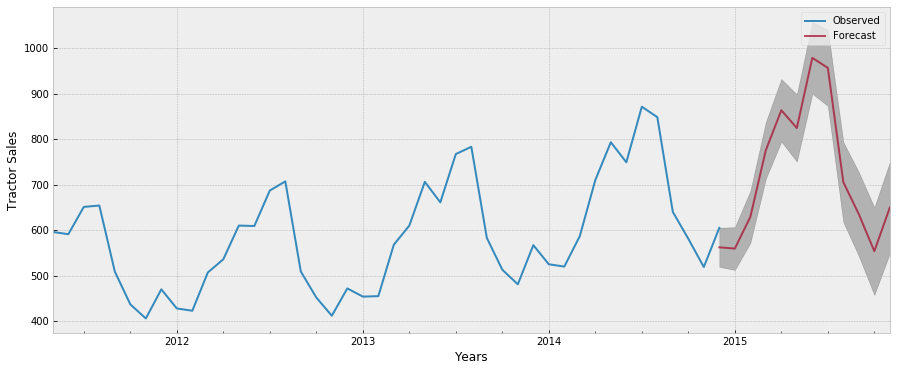

In [117]:
# plot the forecast along with the confidence band
axis = mkt_sales_data['Tractor-Sales'].plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
#axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.25)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

In [118]:
#Diagnostics
    #1. Errors follows normality
    #2. Errors should not have auto correlation (ACF, no spikes beyond the limits)
    #3. Errors should not have any spikes (if the spikes are present, that particular time period, model didn't predict propoerly)


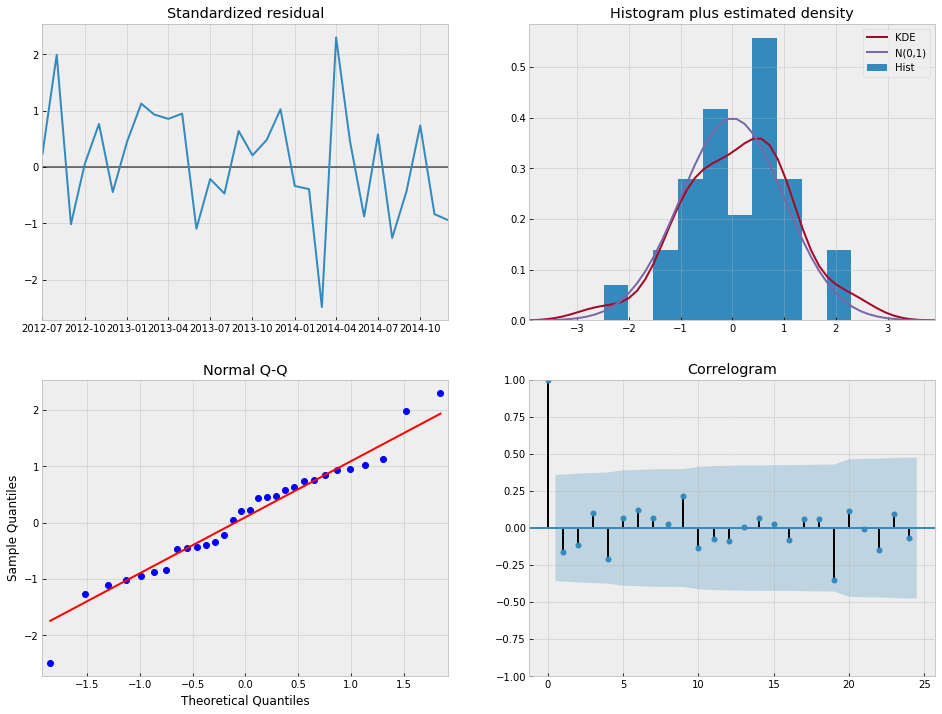

In [119]:
best_results.plot_diagnostics(lags=24, figsize=(16,12))
plt.show()